# Imports

In [28]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

from icedef import iceberg, metocean, drift_simulation, plot
from icedef.turnbull import drift

# Iceberg

In [2]:
df = pd.read_csv('csvs/0204980_2015.csv')

In [3]:
df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

In [4]:
times = [t.to_pydatetime() for t in df['DataDate_UTC']]

In [5]:
times[0]

datetime.datetime(2015, 4, 24, 15, 16, 6)

In [6]:
lons = df['Longitude']

In [7]:
lats = df['Latitude']

In [8]:
ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], 0, 0, 0, 0, 'LG', 'TAB')

In [9]:
ref_berg.history['T'] = times[:100]
ref_berg.history['X'] = lons[:100]
ref_berg.history['Y'] = lats[:100]

In [10]:
berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [11]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

In [12]:
atm_data = metocean.ECMWFAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

In [13]:
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

In [14]:
#sim.euler(0.1*3600, 100)
sim.rk2(0.1*3600, 100)

Iceberg out of bounds


In [15]:
sim.history.head()

,t,vax,vay,vcx,vcy,vx,vy,x,y
0,2015-04-24 15:16:06,-3.276800e+04,-3.276800e+04,4.338267e-02,7.338440e-02,0.000000e+00,0.000000e+00,-5.155144e+01,5.145991e+01
1,None,6.927051e-310,6.927051e-310,6.927051e-310,6.927051e-310,6.927051e-310,6.927051e-310,6.927051e-310,6.927051e-310


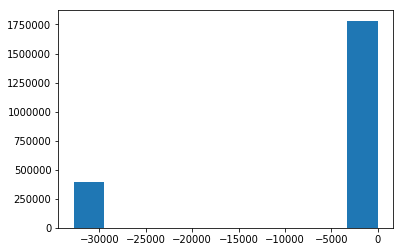

In [16]:
plt.hist(ocean_data.U.flatten())
plt.show()

# Plot

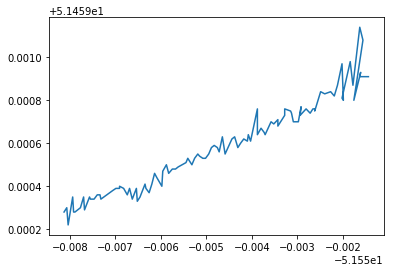

In [17]:
#plt.scatter(sim.history['x'], sim.history['y'])
plt.plot(ref_berg.history['X'], ref_berg.history['Y'])
plt.show()

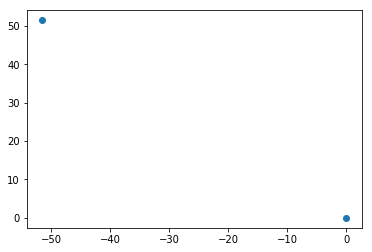

In [18]:
plt.scatter(sim.history['x'], sim.history['y'])
plt.show()

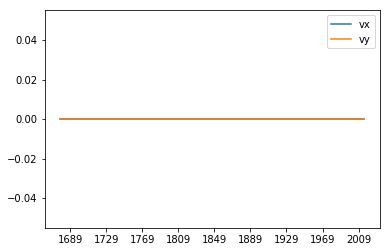

In [19]:
plt.plot(sim.history['t'], sim.history['vx'], label='vx')
plt.plot(sim.history['t'], sim.history['vy'], label='vy')
plt.legend()
plt.show()

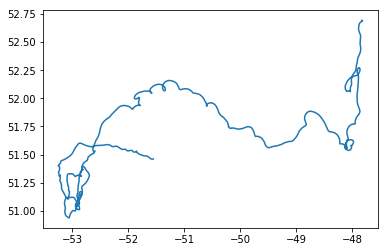

In [20]:
plt.plot(df['Longitude'], df['Latitude'])
plt.show()

In [21]:
bad_ocean_time_idxs, bad_ocean_lat_idxs, bad_ocean_lon_idxs = np.where(abs(ocean_data.U) > 100)
bad_ocean_times = ocean_data.times[bad_ocean_time_idxs]
bad_ocean_lats = ocean_data.lats[bad_ocean_lat_idxs]
bad_ocean_lons = ocean_data.lons[bad_ocean_lon_idxs]

In [26]:
bad_atm_time_idxs, bad_atm_lat_idxs, bad_atm_lon_idxs = np.where(abs(atm_data.U) > 1000)
bad_atm_times = atm_data.times[bad_atm_time_idxs]
bad_atm_lats = atm_data.lats[bad_atm_lat_idxs]
bad_atm_lons = atm_data.lons[bad_atm_lon_idxs]

In [23]:
from icedef import plot

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


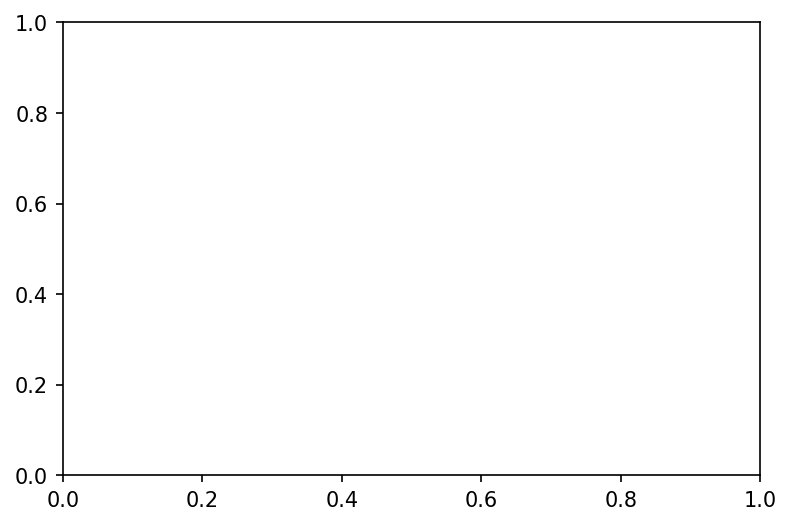

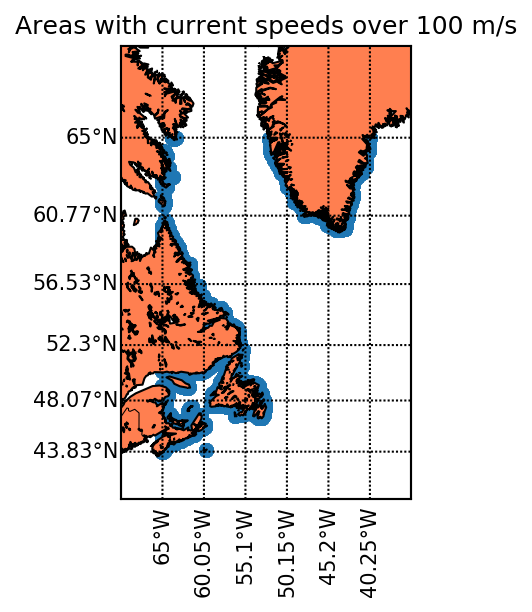

In [24]:
fig, ax = plt.subplots(dpi=150)
m = plot.get_mercator_basemap(bad_ocean_lons[0], bad_ocean_lons[-1], bad_ocean_lats[0], bad_ocean_lats[-1])

xs, ys = m(bad_ocean_lons, bad_ocean_lats)

ax.scatter(xs, ys)
plt.title('Areas with current speeds over 100 m/s')
plt.show()

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


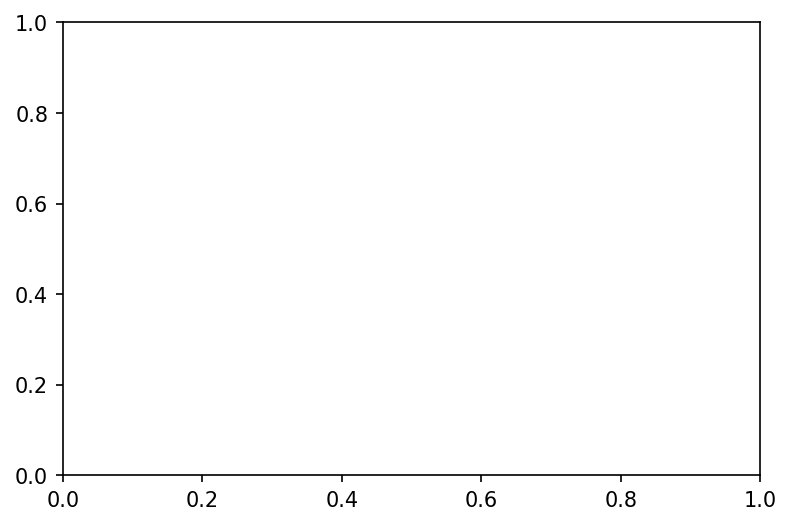

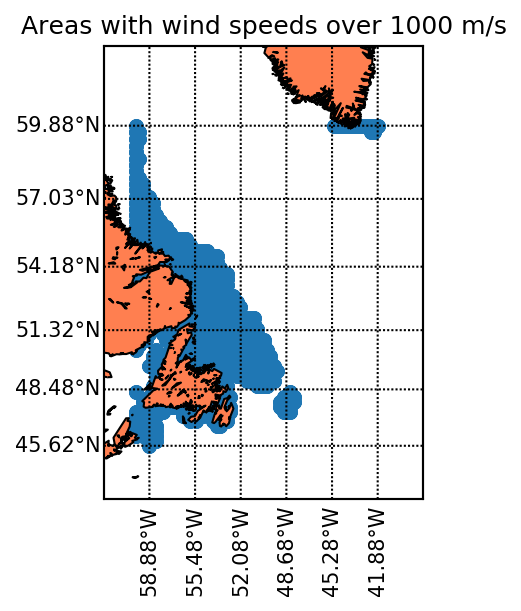

In [27]:
fig, ax = plt.subplots(dpi=150)
m = plot.get_mercator_basemap(bad_atm_lons[0], bad_atm_lons[-1], bad_atm_lats[0], bad_atm_lats[-1])

xs, ys = m(bad_atm_lons, bad_atm_lats)

ax.scatter(xs, ys)
plt.title('Areas with wind speeds over 1000 m/s')
plt.show()